Fig7c, voltage at different segs of the axon during point in time

In [1]:
from neuron import h
import numpy as np
import os.path
import sys
sys.path.append('../../libs/')

In [2]:
# load model
# works only on linux
model = '../../data/morphology/soma_axon.hoc'
dllpath = '../../data/morphology/x86_64/.libs/libnrnmech.so'
h.nrn_load_dll(dllpath)
h.load_file(model)
h.init_cell()

0.0

In [3]:
# parameters
keep_soma_Na = True
soma_size = 30 # 1, 30, 50 um
stim_amp = 0.033
# use different amplitude for stimulation depending on the soma size size:amplitude 
# (1:0.0037,30:0.033,50:0.4)
datapts_time_at_mV=[-54, -58, -40, 30] 

# simulation
h.tstart = 0.
h.tstop = 20.
h.dt = 0.001
rm = 30000.
st_dur1 = 2.
st_dur2 = 3.
v_init = -70

# morphology 
h.soma.L = soma_size
h.soma.diam = soma_size
h.soma.nseg = 1
h.soma.g_pas = 1./rm
h.soma.cm = 0.75

h.axon.L = 50.
h.axon.diam =1.
h.axon.nseg = 101
h.axon.g_pas = 1./rm
h.axon.cm = 0.75 * 0.75

# general
h.rm = rm
h.v_init = v_init
h.ra = 150 
h.c_m = 0.75
h.xn = 1 

# potassium
h.Ek = -80. # mV # Fig2: = 80; Fig4b:
h.gk = 1600.
h.gkm = 0.3
h.soma.gbar_kv = 1600/5.
h.axon.gbar_kv = 1600.

# sodium
h.Ena = 60.
h.gna = 8000.
h.gkm_soma = 0.3
if keep_soma_Na:
    h.soma.gbar_na = 0.1*8000
else:
    h.soma.gbar_na = 0.
h.axon.gbar_na = 8000.
            
# calcium (set no calcium in the model)
h.gca = 0.
h.gkca = 0.
h.gca_soma = 0.
h.gkca_soma = 0.

In [4]:
no_datapts_space = 102
segs_exact = ['axon'] * h.axon.nseg
segs_exact.append('soma')
subsegs = np.linspace(0,1,h.axon.nseg+1)
half_seg = (subsegs[-1] - subsegs[-2])/2.
subsegs = subsegs + half_seg
subsegs[-1] = 0.5 # for soma


assert no_datapts_space == len(subsegs)

In [5]:
# create I-clamp stimulation
st = h.IClamp(0.5, sec = h.soma)
st.dur = 7 # ms
st.delay = 1
st.amp = stim_amp

In [6]:
# record in the soma and in the axon
all_vecs = [h.Vector() for i in range(no_datapts_space)]
for idx,seg in enumerate(segs_exact):
    if seg == 'soma':
        all_vecs[idx].record(h.soma(subsegs[idx])._ref_v, sec=h.soma)
    elif seg == 'axon':
        all_vecs[idx].record(h.axon(subsegs[idx])._ref_v, sec=h.axon)

all_vecs[:-1] = all_vecs[0:-1][::-1]

soma_v = h.Vector()
soma_v.record(h.soma(0.5)._ref_v, sec = h.soma)
h.run()

0.0

/home/maja/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


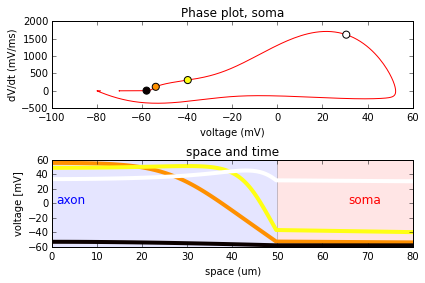

In [7]:
soma_array = np.array(soma_v)

# select time at which to check the voltage across the neuron
time_idx = np.zeros(len(datapts_time_at_mV))
for pt_idx, next_mv in enumerate(datapts_time_at_mV):
    time_idx[pt_idx] = int(np.where(soma_array>next_mv)[0][0])
time_idx=time_idx.astype(int)

data_to_plot = np.zeros([no_datapts_space, len(time_idx)])
from matplotlib import cm, colors
point_colors = cm.hot(colors.Normalize()(time_idx))    

color =['b', 'r']
unik_segs=[segs_exact[i] for i in sorted(np.unique(segs_exact, return_index=True)[1])]

import matplotlib.pylab as plt
%matplotlib inline   

spaceline = subsegs * h.axon.L
spaceline[-1] = h.axon.L + subsegs[-1] * h.soma.L
total_length = h.axon.L + h.soma.L

plt.subplot(2,1,1)
# corresponding phase plot with the scatter plot on top of it
deriv_soma = np.diff(soma_array)/h.dt
plt.plot(soma_array[:-1], deriv_soma, 'r', label = 'soma')
plt.scatter(soma_array[time_idx], (np.diff(soma_array)/h.dt)[time_idx], c=point_colors, s=50, zorder=100)
plt.title('Phase plot, soma')
plt.ylabel('dV/dt (mV/ms)')
plt.xlabel('voltage (mV)')

# space and time plot
# background for segments
plt.subplot(2,1,2)
# axon
p = plt.axvspan(0, h.axon.L, facecolor=color[0], alpha = 0.1)
plt.text(spaceline[0]+1, 0, 'axon', color=color[0], fontsize = 12)
# soma
p = plt.axvspan(h.axon.L, h.axon.L+h.soma.L, facecolor=color[1], alpha = 0.1)
plt.text(spaceline[-1]+1, 0, 'soma', color=color[1], fontsize = 12)

for space in range(no_datapts_space):   
    v_cell = np.array(all_vecs[space])[time_idx]
    data_to_plot[space,:] = v_cell
    
# shift plotting the first and the last datapts to the beginning and the end of the segment instead of its middle
spaceline[0] = 0 
spaceline[-1] = h.axon.L+h.soma.L

for i in range(data_to_plot.shape[1]):
    plt.plot(spaceline, data_to_plot[:, i], color=point_colors[i], lw=4)
plt.title('space and time')
plt.xlim([0,np.sum(total_length)])
plt.xlabel('space (um)')
plt.ylabel('voltage [mV]')

plt.tight_layout()